In [3]:
!pip install prophet

     -------------------------------------- 12.1/12.1 MB 475.1 kB/s eta 0:00:00
     -------------------------------------- 83.2/83.2 kB 310.7 kB/s eta 0:00:00
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached holidays-0.21.13-py3-none-any.whl (378 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached PyMeeus-0.5.12.tar.gz (5.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached korean_lunar_calendar-0.3.1-py3-none-any.whl (9.0 kB)
  Using cached hijri_converter-2.2.4-py3-none-any.whl (14 kB)
  Using cached ephem-4.1.4-cp39-cp39-win_amd64.whl (1.4 MB)
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732051 sha256=d40450bda46ea1b81f03e95beb3d2fa4545d93c2cc06e093849cd64f03f5007d
  Stored in directory: c:\users\prash\appdata\local\pip\cache\wheels\9b\0a\31\eb0e590d74ec13e90493cb6d1cd92a379a1a3b8f12ed778a14
Successfully built pymeeus


In [1]:
from prophet import Prophet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Data
The data we will be using is hourly power consumption data from PJM. Energy consumption has some unique characteristics. It will be interesting to see how prophet picks them up.

Pulling the PJM East which has data from 2002-2018 for the entire east region

In [3]:
pjmw = pd.read_excel('PJMW_MW_Hourly (2).xlsx',
                   index_col=[0],
                  parse_dates=[0])
pjmw.head()

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077
2002-12-31 02:00:00,4939
2002-12-31 03:00:00,4885
2002-12-31 04:00:00,4857
2002-12-31 05:00:00,4930


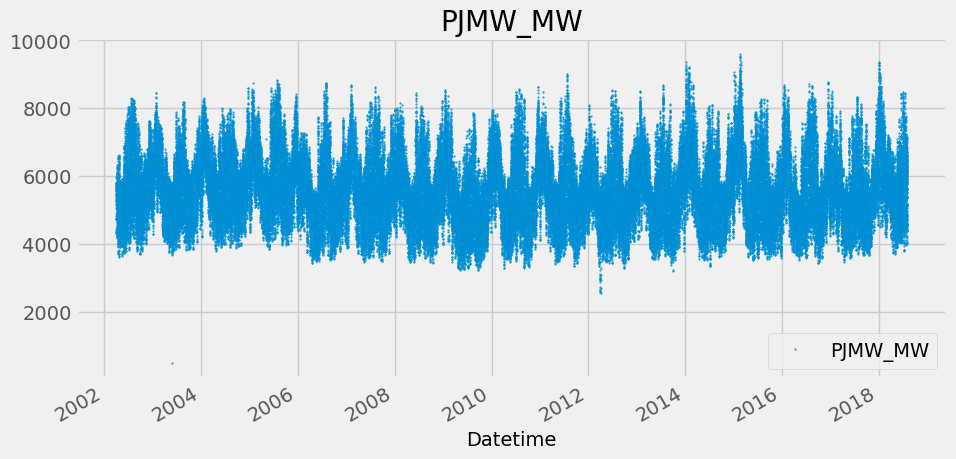

In [4]:
color_pal = sns.color_palette()
pjmw.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='PJMW_MW')
plt.show()


# Time Series Features

In [5]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjmw, label='PJMW_MW')
features_and_target = pd.concat([X, y], axis=1)

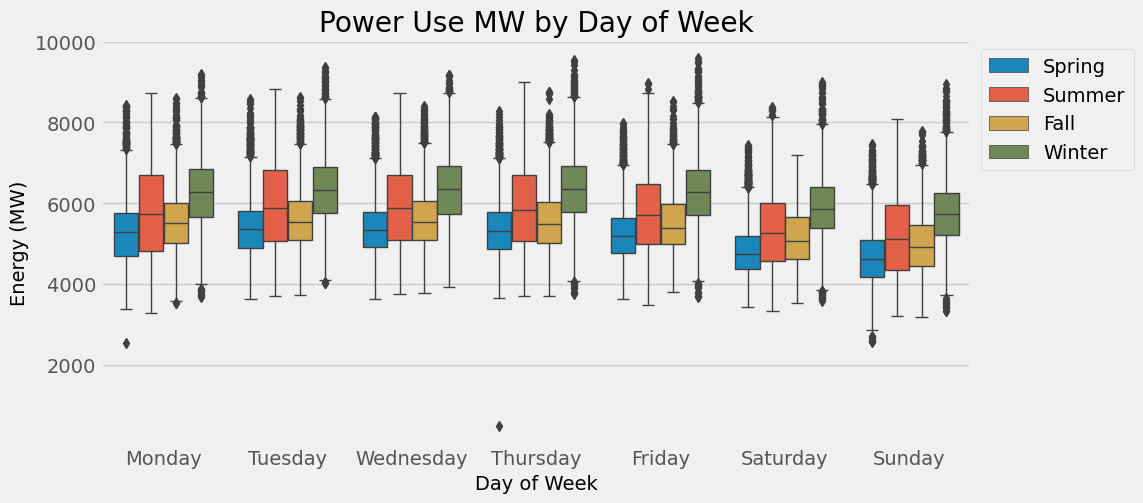

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJMW_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

# Train / Test Split

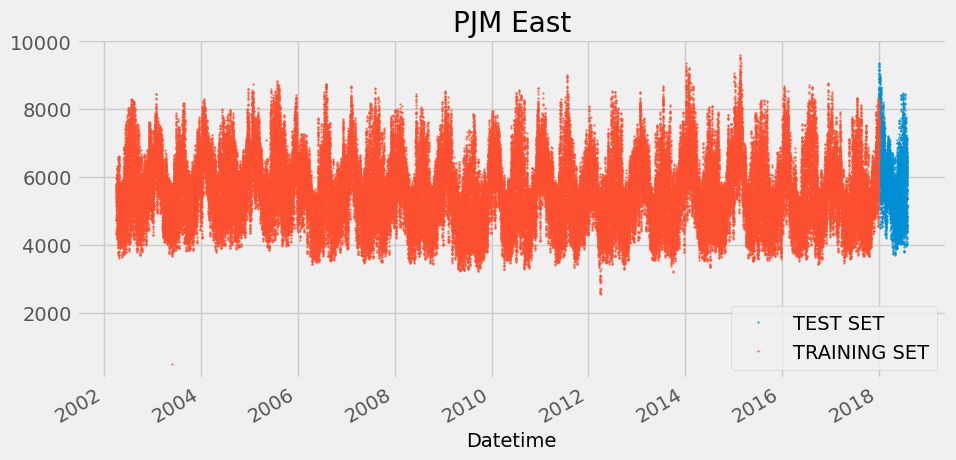

In [11]:
split_date = '1-Jan-2018'
pjmw_train = pjmw.loc[pjmw.index <= split_date].copy()
pjmw_test = pjmw.loc[pjmw.index > split_date].copy()

# Plot train and test so you can see where we have split
pjmw_test \
    .rename(columns={'PJMW_MW': 'TEST SET'}) \
    .join(pjmw_train.rename(columns={'PJMW_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

# Simple Prophet Model
Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.                                                                                                                       
Datetime column named: ds                                                                                                   
target : y

In [12]:
# Format data for prophet model using ds and y
pjmw_train_prophet = pjmw_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJMW_MW':'y'})

In [13]:
%%time
model = Prophet()
model.fit(pjmw_train_prophet)

19:16:27 - cmdstanpy - INFO - Chain [1] start processing
19:18:36 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 24.4 s
Wall time: 2min 34s


In [16]:
pjmw_test_prophet = pjmw_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJMW_MW':'y'})

In [17]:
pjmw_test_fcst = model.predict(pjmw_test_prophet)

In [18]:
pjmw_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01 01:00:00,5483.103387,4328.209959,5800.912396,5483.103387,5483.103387,-439.378773,-439.378773,-439.378773,-631.460670,...,-169.678437,-169.678437,-169.678437,361.760333,361.760333,361.760333,0.0,0.0,0.0,5043.724614
1,2018-01-01 02:00:00,5483.097824,4170.452077,5593.899450,5483.097824,5483.097824,-620.857326,-620.857326,-620.857326,-840.172484,...,-143.029191,-143.029191,-143.029191,362.344349,362.344349,362.344349,0.0,0.0,0.0,4862.240498
2,2018-01-01 03:00:00,5483.092261,3995.669180,5443.844263,5483.092261,5483.092261,-702.483989,-702.483989,-702.483989,-948.843328,...,-116.578211,-116.578211,-116.578211,362.937549,362.937549,362.937549,0.0,0.0,0.0,4780.608272
3,2018-01-01 04:00:00,5483.086698,4107.966853,5571.897605,5483.086698,5483.086698,-674.265136,-674.265136,-674.265136,-947.338165,...,-90.466896,-90.466896,-90.466896,363.539925,363.539925,363.539925,0.0,0.0,0.0,4808.821562
4,2018-01-01 05:00:00,5483.081136,4205.920537,5658.488746,5483.081136,5483.081136,-529.767044,-529.767044,-529.767044,-829.087674,...,-64.830840,-64.830840,-64.830840,364.151470,364.151470,364.151470,0.0,0.0,0.0,4953.314092


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

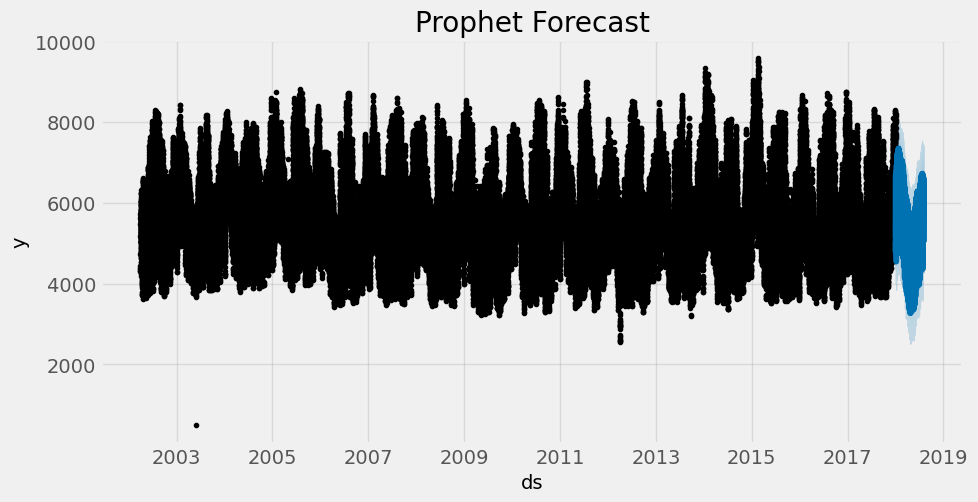

In [19]:
fig = model.plot(pjmw_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

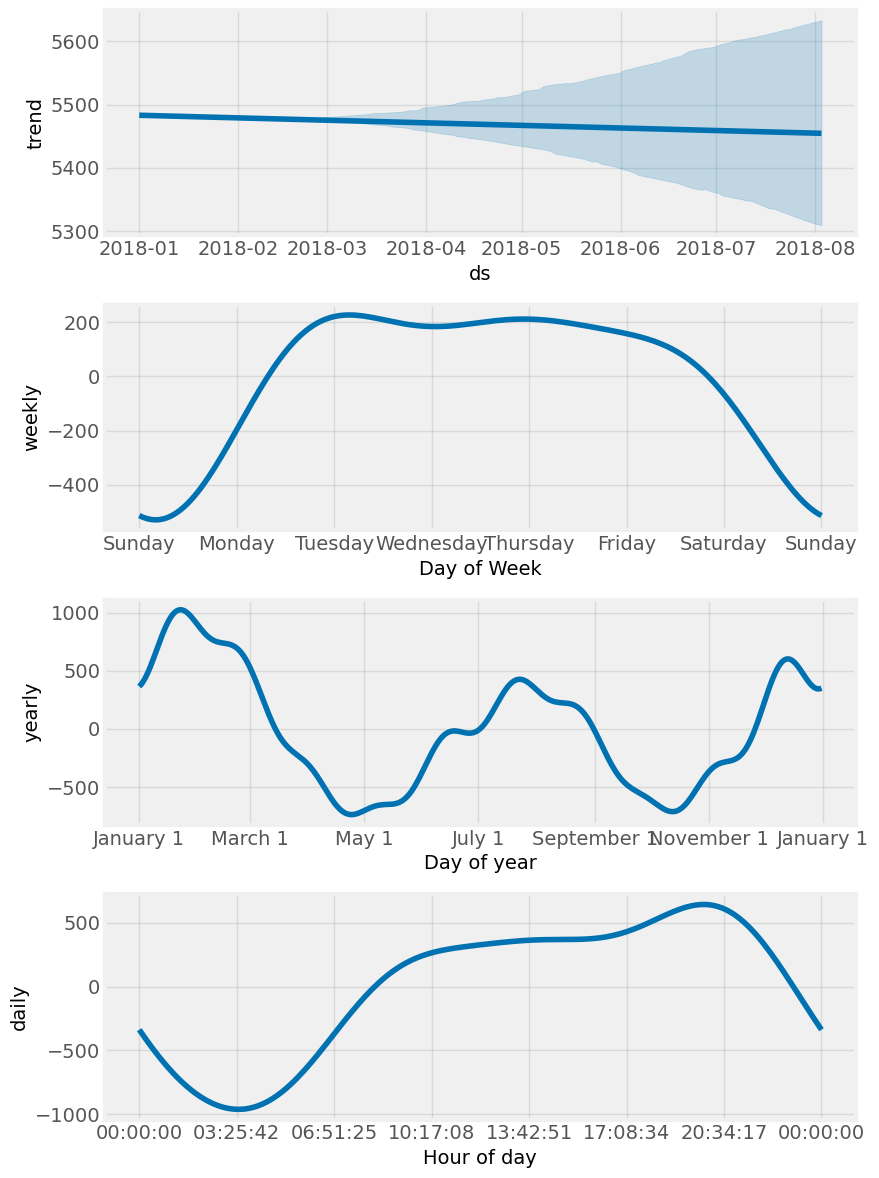

In [20]:
fig = model.plot_components(pjmw_test_fcst)
plt.show()

# Compare Forecast to Actuals

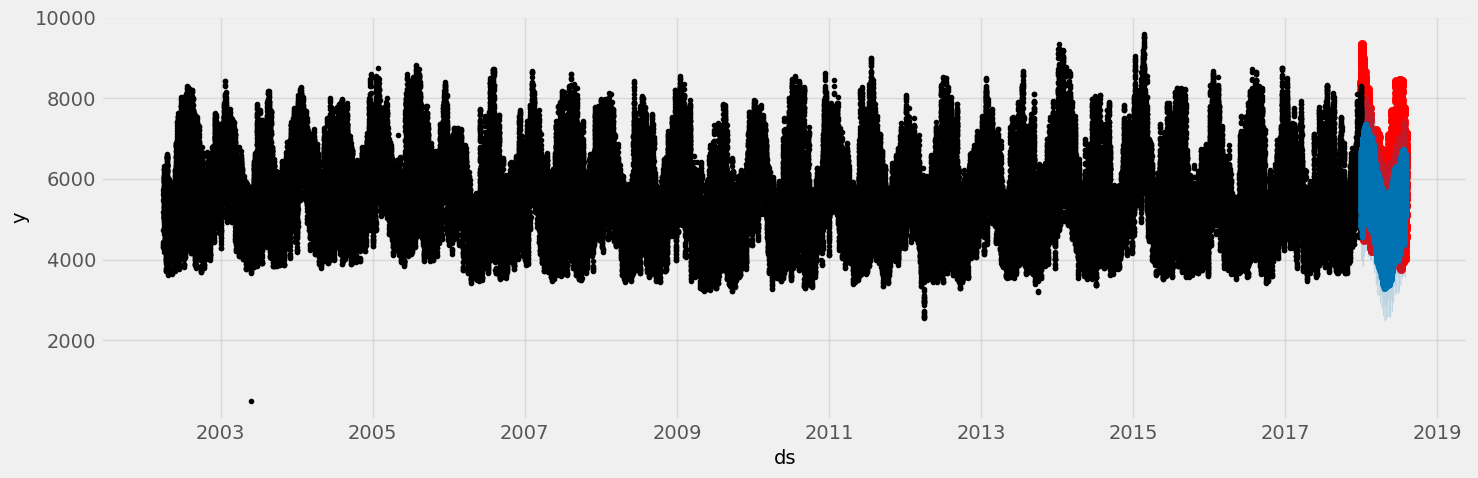

In [22]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjmw_test.index, pjmw_test['PJMW_MW'], color='r')
fig = model.plot(pjmw_test_fcst, ax=ax)

ConversionError: Failed to convert value(s) to axis units: array([datetime.datetime(2002, 4, 1, 1, 0),
       datetime.datetime(2002, 4, 1, 2, 0),
       datetime.datetime(2002, 4, 1, 3, 0), ...,
       datetime.datetime(2017, 12, 31, 22, 0),
       datetime.datetime(2017, 12, 31, 23, 0),
       datetime.datetime(2018, 1, 1, 0, 0)], dtype=object)

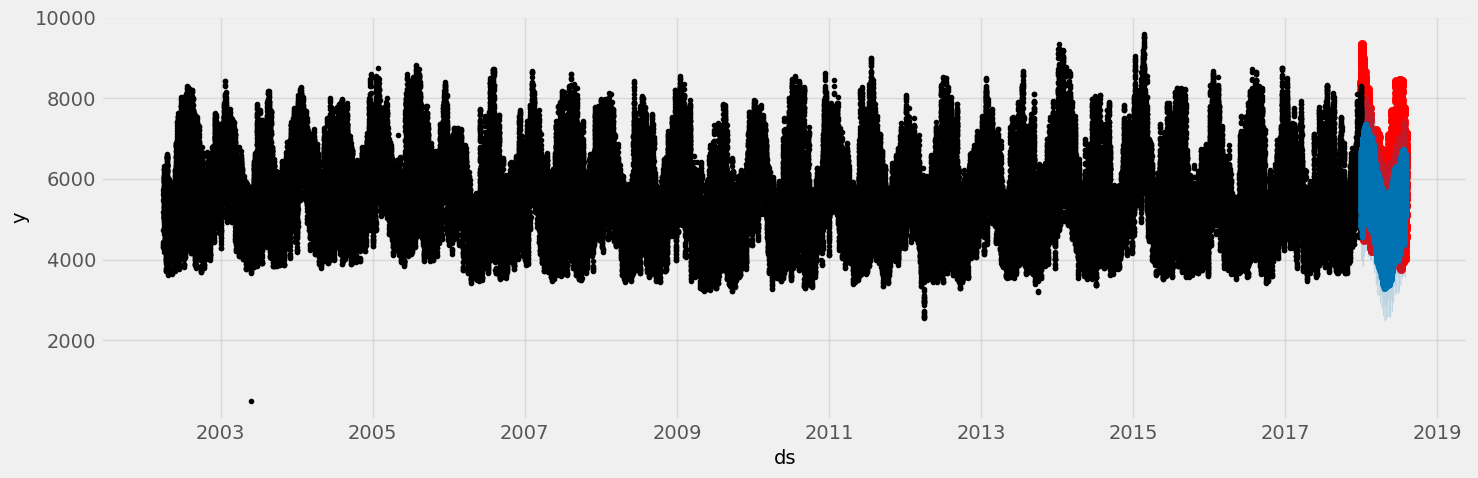

In [26]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjmw_test.index, pjmw_test['PJMW_MW'], color='r')
fig = model.plot(pjmw_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2018', upper='01-08-2018')
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

# Evaluate the model with Error Metrics


In [28]:
np.sqrt(mean_squared_error(y_true=pjmw_test['PJMW_MW'],
                   y_pred=pjmw_test_fcst['yhat']))

1019.563463910997

In [29]:
mean_absolute_error(y_true=pjmw_test['PJMW_MW'],
                   y_pred=pjmw_test_fcst['yhat'])

795.7450142209033

In [30]:
mean_absolute_percentage_error(y_true=pjmw_test['PJMW_MW'],
                   y_pred=pjmw_test_fcst['yhat'])

13.382534656987904

# Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays


In [32]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjmw.index.min(),
                        end=pjmw.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})


In [33]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjmw_train_prophet)

19:24:54 - cmdstanpy - INFO - Chain [1] start processing
19:28:14 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 29.1 s
Wall time: 3min 50s


In [34]:
# Predict on training set with model
pjmw_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjmw_test_prophet)

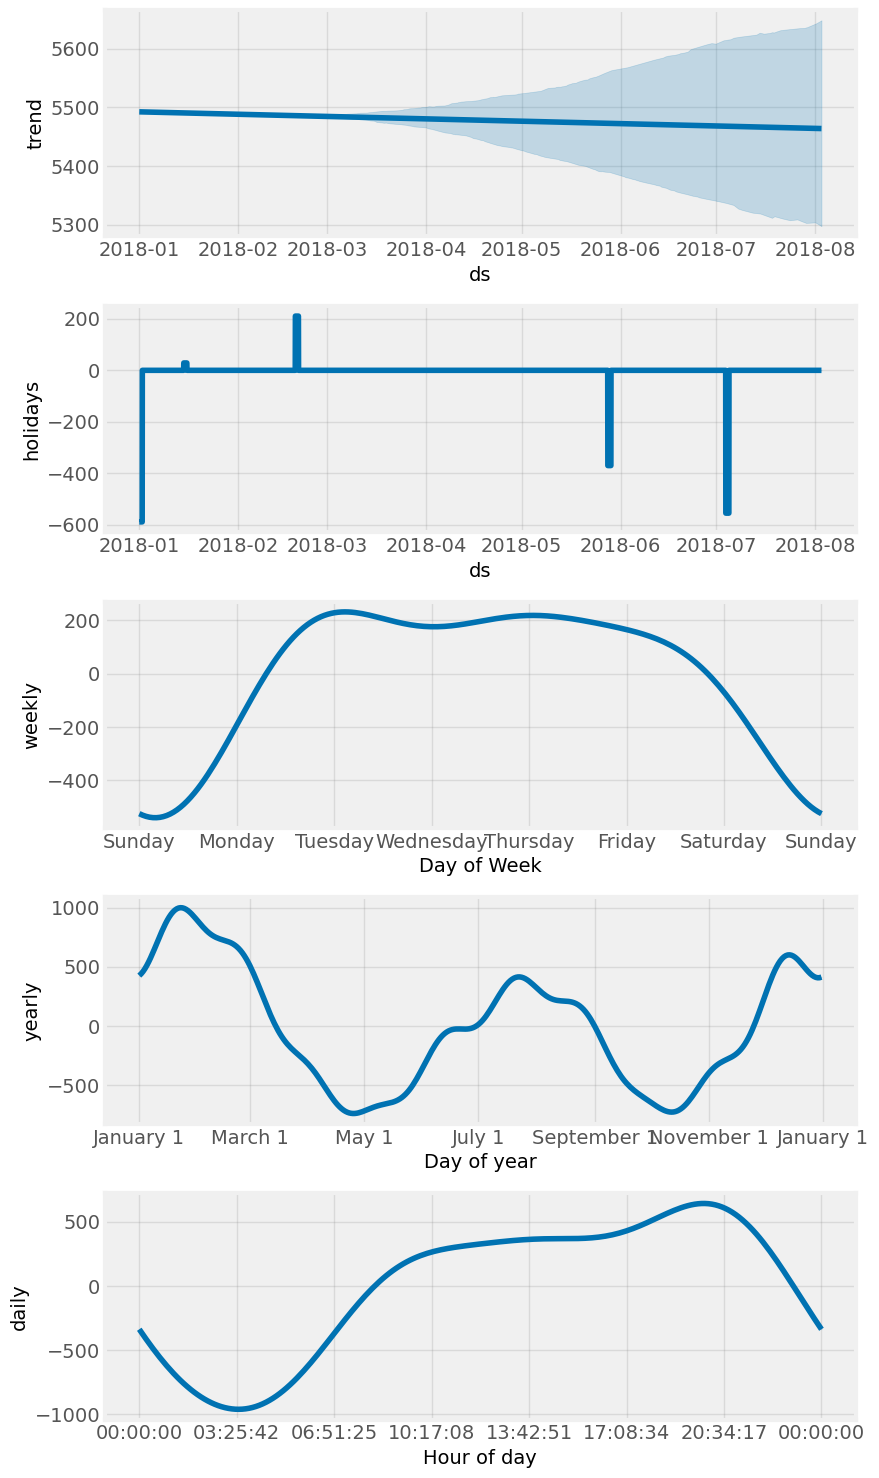

In [35]:
fig = model_with_holidays.plot_components(
    pjmw_test_fcst_with_hols)
plt.show()

ConversionError: Failed to convert value(s) to axis units: array([datetime.datetime(2002, 4, 1, 1, 0),
       datetime.datetime(2002, 4, 1, 2, 0),
       datetime.datetime(2002, 4, 1, 3, 0), ...,
       datetime.datetime(2017, 12, 31, 22, 0),
       datetime.datetime(2017, 12, 31, 23, 0),
       datetime.datetime(2018, 1, 1, 0, 0)], dtype=object)

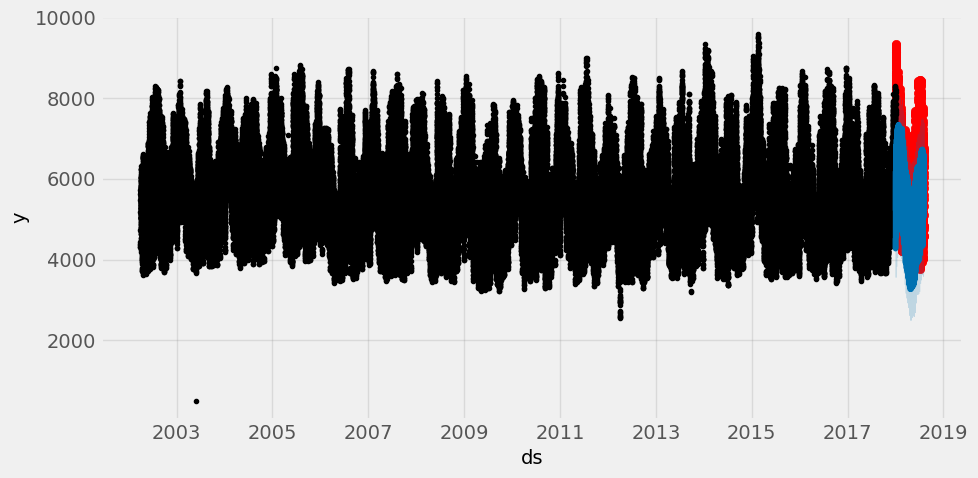

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjmw_test.index, pjmw_test['PJMW_MW'], color='r')
fig = model.plot(pjmw_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower='01-01-2018',
              upper='01-07-2018')
ax.set_ylim(0, 60000)
plot = plt.suptitle('Jan  Predictions vs Actual')

In [37]:
np.sqrt(mean_squared_error(y_true=pjmw_test['PJMW_MW'],
                   y_pred=pjmw_test_fcst_with_hols['yhat']))

1022.1647019547935

In [38]:
mean_absolute_error(y_true=pjmw_test['PJMW_MW'],
                   y_pred=pjmw_test_fcst_with_hols['yhat'])

798.368840743182

# Predict into the Future
We can use the built in make_future_dataframe method to build our future dataframe and make predictions.



In [39]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [40]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2018-01-01 01:00:00,4529.719895
1,2018-01-01 02:00:00,4349.000538
2,2018-01-01 03:00:00,4268.098467
3,2018-01-01 04:00:00,4297.010048
4,2018-01-01 05:00:00,4442.159691


In [41]:
forecast[['ds','yhat']].tail()

,ds,yhat
8755,2018-12-31 20:00:00,6713.564121
8756,2018-12-31 21:00:00,6632.643311
8757,2018-12-31 22:00:00,6410.581556
8758,2018-12-31 23:00:00,6092.427848
8759,2019-01-01 00:00:00,5754.382129
